In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import time
import pickle
from datetime import datetime

# Analysis of E-Mini S&P 500 Futures Tick Data

In this notebook, we will be exploring the properties of data representing the tick-by-tick transactions involving E-Mini S&P 500 Futures. In my experience, tick data is the most granular data you can have on any given asset, and is naturally frequently used in low-latency trading. Let us see if we can find some interesting results!

# Importing the Data

We will begin this project by taking a look at the data. I am unfamiliar with this type of file extension, so we will get to learn something new!

In [86]:
# Data inspection
data = h5py.File('ES.h5', 'r')

In [87]:
# Behaves like some sort of dictionary
data.keys()

<KeysViewHDF5 ['tick']>

In [88]:
tick = data.get('tick')
tick.keys()

<KeysViewHDF5 ['trades', 'trades_filter0vol']>

In [89]:
# Let's see how many transactions there are...
trades = tick.get('trades')
trades.size

903298560

This dataset is massive! I have never had the opportunity to work with such a large dataset. It will be likely that I will have to work with a subset of this data. There is no way that I could manipulate such a large dataframe with the slow CPU clock/low RAM on my laptop (maybe if I have time leftover I will rent an AWS instance and give this a try). 

In [90]:
trades.dtype

dtype([('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [91]:
trades[-1]

(b'ESZ15', 1992.25, b'20151013155959134', 2)

These dates are formatted interestingly. I assume it is:

Year Month Day Hour Minute Second Millisecond Microsecond(?). This is certainly the most granular data I've ever worked with before!

I will now explore the other part of the dataset:

In [92]:
other = tick.get('trades_filter0vol')
other.size

856183065

In [93]:
# What is this? 
trades.size - other.size

47115495

In [94]:
other.dtype

dtype([('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

This other dataset appears to be formatted the same way...

In [95]:
other[-1]

(b'ESZ15', 1992.25, b'20151013155959134', 2)

Start with a small sample to compare:

In [96]:
sample = trades[:10000000]
samp_filt = other[:1000000]

In [97]:
# Is it called 0vol because those are orders that don't get filled? 
sample[:10]

array([(b'ESU97', 933.75, b'19970910001318000', 0),
       (b'ESU97', 933.75, b'19970910010809000', 0),
       (b'ESU97', 934.  , b'19970910011146000', 0),
       (b'ESU97', 933.75, b'19970910011819000', 0),
       (b'ESU97', 933.75, b'19970910012349000', 0),
       (b'ESU97', 933.75, b'19970910012352000', 0),
       (b'ESU97', 934.  , b'19970910020654000', 0),
       (b'ESU97', 934.  , b'19970910020738000', 0),
       (b'ESU97', 934.  , b'19970910023013000', 0),
       (b'ESU97', 934.25, b'19970910025316000', 0)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [98]:
samp_filt[:10]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2),
       (b'ESU03', 971.75, b'20030630230141000', 3),
       (b'ESU03', 972.  , b'20030630230155000', 1),
       (b'ESU03', 972.  , b'20030630230157000', 1),
       (b'ESU03', 972.  , b'20030630230158000', 1),
       (b'ESU03', 972.  , b'20030630230417000', 3),
       (b'ESU03', 971.75, b'20030630230508000', 5),
       (b'ESU03', 971.75, b'20030630230509000', 5)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [99]:
# Yes! These are the trades we want to work with surely... 

In [100]:
sum(sample['Volume'])

0

In [101]:
del sample

We will want to naturally work with the ticks that have volume attached to them. Otherwise, they would not be considered a transaction and the values would just be orders. As we know from the car problem, you can set a price to whatever you want, but your product will not necessarily be purchased for that price!

We will work with a subsample here because my computing power is far too weak to make this feasible...

In [15]:
# Create a subset to work on
samp_filt = tick.get('trades_filter0vol')

Now, we will try to roll these prices so that they represent one continuous price series:

In [20]:
samp_filt[:10]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2),
       (b'ESU03', 971.75, b'20030630230141000', 3),
       (b'ESU03', 972.  , b'20030630230155000', 1),
       (b'ESU03', 972.  , b'20030630230157000', 1),
       (b'ESU03', 972.  , b'20030630230158000', 1),
       (b'ESU03', 972.  , b'20030630230417000', 3),
       (b'ESU03', 971.75, b'20030630230508000', 5),
       (b'ESU03', 971.75, b'20030630230509000', 5)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [21]:
# Artifact from when I was trying to work with the full set
#prices = [samp_filt[x][1] for x in range(len(samp_filt))]

In [22]:
#file = open('prices_list.pkl', "wb")
#pickle.dump(prices, file)

We want to find out where each contract's data starts and ends:

In [23]:
# Find unique futures codes, the index at which they first appear
vals, idx_start= np.unique(samp_filt['Instrument'], return_index=True)

In [24]:
idx_start

array([  8352408,  32703627,  58697500,  73799504, 102330809, 167689596,
       235317889, 351382954, 481868637, 589024573, 691183251, 796787055,
        14213073,  38264918,  62336729,  77454123, 115079868, 185194992,
       257059138, 372085183, 506468725, 608752339, 716181267, 827140901,
               0,  21565554,  45507019,  66342715,  81885706, 125688647,
       201521272, 290686719, 396383493, 534990221, 639529953, 741196477,
       837922627,   2984986,  27008947,  51537912,  70417557,  92516505,
       137817608, 212889822, 323303819, 435729824, 563414413, 666298742,
       763650498, 851050729])

In [26]:
with open('idx_start.pkl', 'wb') as f:
    pickle.dump(idx_start, f)

In [27]:
with open('vals.pkl', 'wb') as f:
    pickle.dump(vals, f)

In [28]:
# List the contract names
vals

array([b'ESH04', b'ESH05', b'ESH06', b'ESH07', b'ESH08', b'ESH09',
       b'ESH10', b'ESH11', b'ESH12', b'ESH13', b'ESH14', b'ESH15',
       b'ESM04', b'ESM05', b'ESM06', b'ESM07', b'ESM08', b'ESM09',
       b'ESM10', b'ESM11', b'ESM12', b'ESM13', b'ESM14', b'ESM15',
       b'ESU03', b'ESU04', b'ESU05', b'ESU06', b'ESU07', b'ESU08',
       b'ESU09', b'ESU10', b'ESU11', b'ESU12', b'ESU13', b'ESU14',
       b'ESU15', b'ESZ03', b'ESZ04', b'ESZ05', b'ESZ06', b'ESZ07',
       b'ESZ08', b'ESZ09', b'ESZ10', b'ESZ11', b'ESZ12', b'ESZ13',
       b'ESZ14', b'ESZ15'], dtype='|S5')

In [29]:
idxdict = {vals[i]:idx_start[i] for i in range(len(vals))}

In [30]:
# Sanity check
idxdict[b'ESU03']

0

In [32]:
ordered_ticks = sorted(idxdict, key=lambda k: idxdict[k])
ordered_ticks[:5]

[b'ESU03', b'ESZ03', b'ESH04', b'ESM04', b'ESU04']

In [ ]:
# Looks good to me!

In [35]:
# First time one of the ESZ03 contracts is traded
print(samp_filt[idxdict[ordered_ticks[1]]][2])

# Last time one of the ESU03 contracts is traded
print(samp_filt[idxdict[ordered_ticks[1]]-1][2])

b'20030910154500000'
b'20030910151459000'


In [36]:
samp_filt[idxdict[ordered_ticks[1]]][2] > samp_filt[idxdict[ordered_ticks[1]]-1][2]

True

In [37]:
samp_filt[idxdict[b'ESH04']]

(b'ESH04', 1059.5, b'20031210153001000', 1)

In [38]:
samp_filt[idxdict[b'ESH04']-1]

(b'ESZ03', 1061., b'20031210151459000', 5)

It seems like the continuous price series has already been completed? 

In [45]:
# Check
is_ordered = []
for i in range(1,len(idxdict.keys())):
    key = list(idxdict.keys())[i]
    first_time = samp_filt[idxdict[ordered_ticks[1]]][2]
    last_time = samp_filt[idxdict[ordered_ticks[1]]-1][2]
    
    is_ordered.append(first_time>last_time)

all(is_ordered)

True

In that case, I think we can move on(?) First, we will delete some unnecessary data to free up some RAM

# Forming Bars

## Tick Bars

Tick bars are bars which sample over a certain amount of trades. Each transaction creates a respective tick, and by sampling all these ticks, we can gain some insight on the price movement, volume movement, etc. over the past $n$ trades:

In [103]:
# Say ticks of len 50000
len(samp_filt) // 50000

20

In [104]:
50000*17123

856150000

In [105]:
len(samp_filt) - 856150000

-855150000

In [106]:
ticks_nminus1 = samp_filt[:50000*17123]

In [62]:
split_nminus1 = np.array_split(ticks_nminus1, 17123, axis=0)
split_nminus1[0]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2), ...,
       (b'ESU03', 970.  , b'20030701130455000', 1),
       (b'ESU03', 969.75, b'20030701130456000', 1),
       (b'ESU03', 969.75, b'20030701130456000', 1)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [65]:
split_n = split_nminus1 + [samp_filt[50000*17123:]]
len(split_n[-1])

33065

In [31]:
print(end-start)

18.496058225631714


In [32]:
len(tick_dict[0])

5000

In [36]:
# # Slow, old version!
# # Initialize the DataFrame
# tick_bars = pd.DataFrame(columns=['Last_Time', 'VWAP', 'Open', 'Close', 'High', 'Low', 'Volume', 'nTicks'])

# # Start timer
# start = time.time()
# for i in range(1000):#len(split_n)):
    
#     # Pull each sample 
#     bar = split_n[i]
    
#     # Calculate the necessary values
#     last_time  = bar["Time"][-1]
#     vwap       = sum(bar['Price']*bar['Volume'])/sum(bar['Volume'])
#     openpx     = bar['Price'][0]
#     closepx    = bar['Price'][-1]
#     high       = max(bar['Price'])
#     low        = min(bar['Price'])
#     volume     = sum(bar['Volume'])
#     nticks     = len(bar)
    
#     # Append to DataFrame
#     tick_bars.loc[i] = [last_time, vwap, openpx, closepx, high, low, volume, nticks]
# end = time.time()

In [85]:
# Form each column of our new dataframes
last_times  = [split_n[i][-1]['Time'] for i in range(len(split_n))]
openpx      = [split_n[i][0]['Price'] for i in range(len(split_n))]
closepx     = [split_n[i][-1]['Price'] for i in range(len(split_n))]
high        = [np.max(split_n[i]['Price']) for i in range(len(split_n))]
low         = [np.min(split_n[i]['Price']) for i in range(len(split_n))]
volume      = [np.sum(split_n[i]['Volume']) for i in range(len(split_n))]
ticks       = [len(x) for x in split_n]

In [88]:
tick_bars_array = np.column_stack([last_times, openpx, high, low, closepx, volume, ticks])
tick_bars_array[:5]

array([[b'20030701130456000', b'971.75', b'975.0', b'960.25', b'969.75',
        b'535697', b'50000'],
       [b'20030702101221000', b'969.75', b'988.5', b'968.5', b'985.0',
        b'544351', b'50000'],
       [b'20030703090805000', b'985.0', b'994.0', b'983.5', b'990.5',
        b'469973', b'50000'],
       [b'20030707093010000', b'990.75', b'1004.25', b'974.5', b'1003.0',
        b'520279', b'50000'],
       [b'20030708090527000', b'1003.0', b'1005.0', b'997.5', b'998.0',
        b'513521', b'50000']], dtype='|S32')

In [89]:
with open('tick_bars_array.pkl', 'wb') as f:
    pickle.dump(tick_bars_array, f)

In [16]:
tick_bars_array = pickle.load(open('tick_bars_array.pkl', 'rb'))

In [17]:
tick_bars_df = pd.DataFrame(tick_bars_array)
tick_bars_df.columns = ['Last Trade', 'Open', 'High', 'Low', 'Close', 'Volume', 'nTicks']

In [39]:
# Sanity Check
tick_bars_df.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
0,b'20030701130456000',b'971.75',b'975.0',b'960.25',b'969.75',b'535697',b'50000'
1,b'20030702101221000',b'969.75',b'988.5',b'968.5',b'985.0',b'544351',b'50000'
2,b'20030703090805000',b'985.0',b'994.0',b'983.5',b'990.5',b'469973',b'50000'
3,b'20030707093010000',b'990.75',b'1004.25',b'974.5',b'1003.0',b'520279',b'50000'
4,b'20030708090527000',b'1003.0',b'1005.0',b'997.5',b'998.0',b'513521',b'50000'


As we can see in the above DataFrame, each bar represents a sample of data spanning 5000 ticks!

In [98]:
pickle.dump(tick_bars_df, open('tick_bars_df.pkl','wb'))

In [103]:
len(tick_bars_df)

17124

## Volume Bars

Next, we will construct volume bars. Volume bars are similar to tick bars, except we are sampling over a fixed number of contracts traded. This differs from tick bars as each transaction may be for more than one contract, which means that our fixed number (say 5000 contracts traded) may be reached before 5000 transactions occur!

In [17]:
# Create a series with all the volumes
volumes = samp_filt['Volume']

In [19]:
# Take the cumulative sum of all volumes
volumes_cumsum = np.cumsum(volumes)
volumes_cumsum

array([         1,          2,          4, ..., 4806457087, 4806457091,
       4806457093], dtype=uint64)

In [20]:
# Find an appropriate volume to sample over
volumes_cumsum[-1] // 300000

16021.0

In [21]:
# Let's say every 300000 units of volume
nvolume = 300000

# If the volume is >= 30000*i, then we start a new bar
# Don't want to split trades, I'm not sure that's allowed,
# so we will be 30000+/- the leftovers per transaction. 

nvols = int(volumes_cumsum[-1] // 300000)

It is important to pause here and elaborate on the above comments. Intuitively, it does not make sense to split transactions to ensure even volumes per bar. We cannot guarantee that the next trade that comes in will only have Volume=1 if we do some sort of prediction model.

In [22]:
# Cutoff points for the bars
thresholds = list(range(0,300000*nvols+1, 300000)) + [volumes_cumsum[-1]]

In [24]:
# Total number of contracts traded
volumes_cumsum[-1]

4806457093

In [25]:
# Sanity Check
thresholds[-1] + 300000 > volumes_cumsum[-1]

True

In [26]:
# Sanity Check x2
thresholds[:5]

[0, 300000, 600000, 900000, 1200000]

In [127]:
# # Old
# start = time.time()
# vol_idx = []
# counter = 0
# for i in range(1000000):#len(volumes_cumsum)):
#     if volumes_cumsum[i] > thresholds[counter]:
#         vol_idx.append(i-1)
#         counter+=1
# end = time.time()

In [27]:
import bisect

# Find indices to split on based on cumulative
# Sum of volume
vol_idxes = []
for threshold in thresholds:
    vol_idxes.append(bisect.bisect_right(volumes_cumsum, threshold))

In [28]:
vol_idxes[:10]

[0, 25999, 56271, 82195, 112005, 144637, 174715, 203446, 231839, 263124]

In [29]:
# Split the data on those indices
vol_splits = np.split(samp_filt, vol_idxes)

In [30]:
pickle.dump(vol_splits, open('vol_splits.pkl','wb'))

In [31]:
vol_splits[1]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2), ...,
       (b'ESU03', 962.25, b'20030701094821000', 1),
       (b'ESU03', 962.25, b'20030701094821000', 1),
       (b'ESU03', 962.25, b'20030701094821000', 1)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [42]:
last_times  = [vol_splits[i][-1]['Time'] for i in range(1,len(vol_splits)-2)]
openpx      = [vol_splits[i][0]['Price'] for i in range(1,len(vol_splits)-2)]
closepx     = [vol_splits[i][-1]['Price'] for i in range(1,len(vol_splits)-2)]
high        = [np.max(vol_splits[i]['Price']) for i in range(1,len(vol_splits)-2)]
low         = [np.min(vol_splits[i]['Price']) for i in range(1,len(vol_splits)-2)]
volume      = [np.sum(vol_splits[i]['Volume']) for i in range(1,len(vol_splits)-2)]
ticks       = [len(x) for x in vol_splits[1:len(vol_splits)-2]]

In [58]:
volume_bars_array = np.column_stack([last_times, openpx, high, low, closepx, volume, ticks])

In [59]:
with open('volume_bars_array.pkl', 'wb') as f:
    pickle.dump(volume_bars_array, f)

In [18]:
volume_bars_array = pickle.load(open('volume_bars_array.pkl', 'rb'))

In [19]:
volume_bars_df = pd.DataFrame(volume_bars_array)
volume_bars_df.columns = ['Last Trade', 'Open', 'High', 'Low', 'Close', 'Volume', 'nTicks']

In [42]:
# Sanity Check
volume_bars_df.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
0,b'20030701094821000',b'971.75',b'975.0',b'960.25',b'962.25',b'299957',b'25999'
1,b'20030701132859000',b'962.25',b'976.5',b'961.75',b'976.25',b'300042',b'30272'
2,b'20030702084226000',b'976.5',b'986.25',b'975.25',b'985.75',b'300000',b'25924'
3,b'20030702120524000',b'986.0',b'990.0',b'983.25',b'987.75',b'300001',b'29810'
4,b'20030703085118000',b'987.5',b'994.0',b'984.0',b'988.75',b'299999',b'32632'


## Dollar Bars

Finally, we will construct dollar bars. Dollar bars are sampled every time the price breaks a certain dollar-value threshold. This can happen in one trade, in many trades, and could take millions of transactions if your threshold is large enough. 

In [135]:
prices = samp_filt['Price']

In [136]:
dollar_cumsum = np.diff(prices).cumsum()

Every time the cumulative sum of price movements is greater than 10, we must form a new bar and reset the reference.

In [179]:
dol_idx = []
benchmark = 0
start_time = time.time()
for i in range(len(dollar_cumsum)):
    val = dollar_cumsum[i]
    if np.abs(val-benchmark) > 10:
        dol_idx.append(i)
        benchmark = val
end_time = time.time() 

In [180]:
pickle.dump(dol_idx, open('dol_idx.pkl','wb'))

In [45]:
dol_idx = pickle.load(open('dol_idx.pkl','rb'))

In [21]:
dol_splits = np.split(samp_filt, dol_idx)

In [22]:
pickle.dump(dol_splits, open('dol_splits.pkl','wb'))

In [23]:
dol_splits[0]

array([(b'ESU03', 971.75, b'20030630230001000', 1),
       (b'ESU03', 972.  , b'20030630230005000', 1),
       (b'ESU03', 972.  , b'20030630230009000', 2), ...,
       (b'ESU03', 967.  , b'20030701074751000', 2),
       (b'ESU03', 966.75, b'20030701074753000', 1),
       (b'ESU03', 967.  , b'20030701074753000', 1)],
      dtype=[('Instrument', 'S5'), ('Price', '<f4'), ('Time', 'S17'), ('Volume', '<u4')])

In [24]:
last_times  = [dol_splits[i][-1]['Time'] for i in range(len(dol_splits))]
openpx      = [dol_splits[i][0]['Price'] for i in range(len(dol_splits))]
closepx     = [dol_splits[i][-1]['Price'] for i in range(len(dol_splits))]
high        = [np.max(dol_splits[i]['Price']) for i in range(len(dol_splits))]
low         = [np.min(dol_splits[i]['Price']) for i in range(len(dol_splits))]
volume      = [np.sum(dol_splits[i]['Volume']) for i in range(len(dol_splits))]
ticks       = [len(x) for x in dol_splits]

In [25]:
dollar_bars_array = np.column_stack([last_times, openpx, high, low, closepx, volume, ticks])

In [26]:
with open('dollar_bars_array.pkl', 'wb') as f:
    pickle.dump(dollar_bars_array, f)

In [46]:
dollar_bars_array = pickle.load(open('dollar_bars_array.pkl', 'rb'))

In [47]:
dollar_bars_df = pd.DataFrame(dollar_bars_array)
dollar_bars_df.columns = ['Last Trade', 'Open', 'High', 'Low', 'Close', 'Volume', 'nTicks']

In [28]:
# Sanity Check
dollar_bars_df.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
0,b'20030701074753000',b'971.75',b'975.0',b'966.75',b'967.0',b'13037',b'2827'
1,b'20030701090529000',b'966.75',b'969.75',b'961.5',b'961.5',b'130921',b'11069'
2,b'20030701103005000',b'961.5',b'966.25',b'960.25',b'966.25',b'224061',b'17726'
3,b'20030701122800000',b'966.25',b'971.5',b'962.75',b'971.5',b'128058',b'13376'
4,b'20030701134001000',b'971.5',b'976.75',b'968.5',b'976.75',b'127305',b'13422'


In [152]:
# # Old, Gross
# # Every $2.00 move
# px = prices[0]
# npx = 2.00

# # Append a flag every time price breaks
# # last bar open +/- $2.00
# flag = []

# for i in range(len(prices)):
    
#     # Did the price break the threshold?
#     if np.abs(prices[i] - px) >= npx:
#         flag.append(1)
#         px = prices[i]
#     else:
#         flag.append(0)

# # Count number of flags
# sumflag = np.cumsum(flag)

Now, let's take a look at the size of each dataframe. I tried to pick thresholds such that the values are relatively close, but Dollar bars seem to be exceptionally sensitive. 

In [52]:
len(tick_bars_df)

17124

In [53]:
len(volume_bars_df)

16021

In [54]:
len(dollar_bars_df)

6320

# Counting Bars on Weekly Basis

Now, let's try to answer some questions. We must first try to coerce these date bytes into datetimes, to make the modelling process easier. Let us explore:

In [55]:
tick_bars = tick_bars_df.copy()
volume_bars = volume_bars_df.copy()
dollar_bars = dollar_bars_df.copy()

In [56]:
tick_bars.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
0,b'20030701130456000',b'971.75',b'975.0',b'960.25',b'969.75',b'535697',b'50000'
1,b'20030702101221000',b'969.75',b'988.5',b'968.5',b'985.0',b'544351',b'50000'
2,b'20030703090805000',b'985.0',b'994.0',b'983.5',b'990.5',b'469973',b'50000'
3,b'20030707093010000',b'990.75',b'1004.25',b'974.5',b'1003.0',b'520279',b'50000'
4,b'20030708090527000',b'1003.0',b'1005.0',b'997.5',b'998.0',b'513521',b'50000'


In [57]:
# Date
str(tick_bars['Last Trade'][0])[2:10]

'20030701'

In [58]:
# Whole value
tmp = str(tick_bars['Last Trade'][7000])[2:19]
tmp

'20101203090519000'

In [59]:
# Coerce to datetime
datetime.strptime(tmp, '%Y%m%d%H%M%S%f')

datetime.datetime(2010, 12, 3, 9, 5, 19)

In [60]:
# Convert each date in each bar dataframe to datetime, set the 
# index of each bar df to the dates
for df in [tick_bars, volume_bars, dollar_bars]:
    candidates = [str(x)[2:19] for x in df['Last Trade']]
    converts = [datetime.strptime(x, '%Y%m%d%H%M%S%f') for x in candidates]
    df.index = converts

In [61]:
# Sanity check
tick_bars.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
2003-07-01 13:04:56,b'20030701130456000',b'971.75',b'975.0',b'960.25',b'969.75',b'535697',b'50000'
2003-07-02 10:12:21,b'20030702101221000',b'969.75',b'988.5',b'968.5',b'985.0',b'544351',b'50000'
2003-07-03 09:08:05,b'20030703090805000',b'985.0',b'994.0',b'983.5',b'990.5',b'469973',b'50000'
2003-07-07 09:30:10,b'20030707093010000',b'990.75',b'1004.25',b'974.5',b'1003.0',b'520279',b'50000'
2003-07-08 09:05:27,b'20030708090527000',b'1003.0',b'1005.0',b'997.5',b'998.0',b'513521',b'50000'


In [62]:
volume_bars.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
2003-07-01 09:48:21,b'20030701094821000',b'971.75',b'975.0',b'960.25',b'962.25',b'299957',b'25999'
2003-07-01 13:28:59,b'20030701132859000',b'962.25',b'976.5',b'961.75',b'976.25',b'300042',b'30272'
2003-07-02 08:42:26,b'20030702084226000',b'976.5',b'986.25',b'975.25',b'985.75',b'300000',b'25924'
2003-07-02 12:05:24,b'20030702120524000',b'986.0',b'990.0',b'983.25',b'987.75',b'300001',b'29810'
2003-07-03 08:51:18,b'20030703085118000',b'987.5',b'994.0',b'984.0',b'988.75',b'299999',b'32632'


In [63]:
dollar_bars.head()

,Last Trade,Open,High,Low,Close,Volume,nTicks
2003-07-01 09:05:16,b'20030701090516000',b'971.75',b'975.0',b'961.75',b'961.75',b'140901',b'13682'
2003-07-01 12:28:00,b'20030701122800000',b'961.75',b'971.5',b'960.25',b'971.5',b'355176',b'31316'
2003-07-01 14:54:08,b'20030701145408000',b'971.5',b'981.75',b'968.5',b'981.75',b'294643',b'26798'
2003-07-02 14:12:06,b'20030702141206000',b'981.75',b'992.0',b'980.5',b'992.0',b'528559',b'54216'
2003-07-03 09:38:29,b'20030703093829000',b'992.0',b'994.25',b'982.25',b'982.25',b'315913',b'32399'


Now we can easily use .groupby to group all of these bars into weekly counts:

In [64]:
tick_weekly_count = tick_bars.groupby(pd.Grouper(freq='W')).count()["Last Trade"]
tick_weekly_count.head()

2003-07-06    3
2003-07-13    6
2003-07-20    7
2003-07-27    7
2003-08-03    7
Freq: W-SUN, Name: Last Trade, dtype: int64

In [65]:
volume_weekly_count = volume_bars.groupby(pd.Grouper(freq='W')).count()["Last Trade"]
volume_weekly_count.head()

2003-07-06     6
2003-07-13    10
2003-07-20    12
2003-07-27    11
2003-08-03    12
Freq: W-SUN, Name: Last Trade, dtype: int64

In [66]:
dollar_weekly_count = dollar_bars.groupby(pd.Grouper(freq='W')).count()["Last Trade"]
dollar_weekly_count.head()

2003-07-06    5
2003-07-13    6
2003-07-20    5
2003-07-27    4
2003-08-03    5
Freq: W-SUN, Name: Last Trade, dtype: int64

Now, let's plot these results and see what we find!

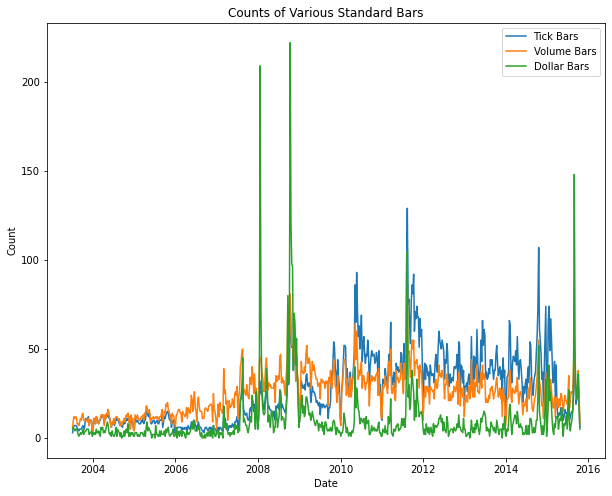

In [67]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(tick_weekly_count, label='Tick Bars')
ax.plot(volume_weekly_count, label='Volume Bars')
ax.plot(dollar_weekly_count, label='Dollar Bars')
plt.legend()
plt.title('Counts of Various Standard Bars')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()

I believe it is safe to say that **dollar bars are the most stable of the three.** I think I can justify this by saying that the volume of a product increases as the price lowers. If an asset manager wants to buy $\$$1 million of ES, they will get more contracts at a lower price, which helps justify why volume is unstable. 

Furthermore, frequency of ticks is likely correlated to liquidity. As order books dry up, there are less transactions, and therefore less ticks. So in a market panic, when liquidity dries up, so does the number of ticks. I suppose we can convince ourselves of this using the large drop in volume and ticks by considering the following charts:

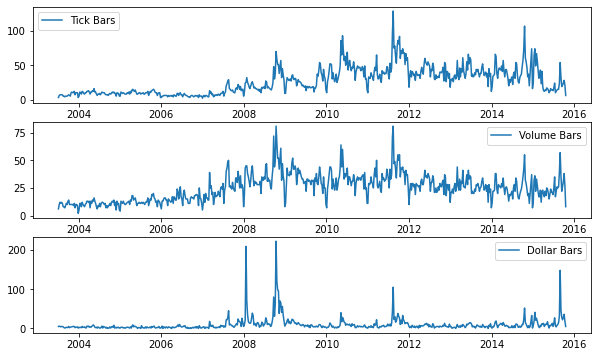

In [69]:
fig, ax = plt.subplots(figsize=(10,6))
ax = plt.subplot(3,1,1)
plt.plot(tick_weekly_count, label='Tick Bars')
plt.legend()
ax = plt.subplot(3,1,2)
plt.plot(volume_weekly_count, label='Volume Bars')
plt.legend()
ax = plt.subplot(3,1,3)
plt.plot(dollar_weekly_count, label='Dollar Bars')
plt.legend()
plt.show()

We can see that dollar bars behave basically the same as VIX. Long periods of calm and large spikes during periods of high volatility. 

# Serial Correlation

Next, we will take a look at the serial correlation of these bars. As the question asks, we will simply compute the serial correlation of each bar type, and see which bar produces the lowest number!

In [70]:
# Convert bytes to numbers for easy manipulation
pd.to_numeric(tick_bars['Close'])

2003-07-01 13:04:56.000     969.75
2003-07-02 10:12:21.000     985.00
2003-07-03 09:08:05.000     990.50
2003-07-07 09:30:10.000    1003.00
2003-07-08 09:05:27.000     998.00
                            ...   
2015-10-12 14:46:03.659    2009.25
2015-10-13 08:31:25.625    1998.50
2015-10-13 10:13:00.268    2014.25
2015-10-13 13:48:16.729    2002.00
2015-10-13 15:59:59.134    1992.25
Name: Close, Length: 17124, dtype: float64

In [71]:
tick_pxrets = pd.DataFrame(pd.to_numeric(tick_bars['Close']).pct_change()[1:], 
                           index=tick_bars.index[1:])

tick_pxrets.columns = ['Tick Bar Returns']
tick_pxrets.head()

,Tick Bar Returns
2003-07-02 10:12:21,0.015726
2003-07-03 09:08:05,0.005584
2003-07-07 09:30:10,0.012620
2003-07-08 09:05:27,-0.004985
2003-07-09 08:36:49,0.009018


In [72]:
volume_pxrets = pd.DataFrame(pd.to_numeric(volume_bars['Close']).pct_change()[1:], 
                           index=volume_bars.index[1:])

volume_pxrets.columns = ['Volume Bar Returns']
volume_pxrets.head()

,Volume Bar Returns
2003-07-01 13:28:59,0.014549
2003-07-02 08:42:26,0.009731
2003-07-02 12:05:24,0.002029
2003-07-03 08:51:18,0.001012
2003-07-03 11:32:48,-0.002781


In [73]:
dollar_pxrets = pd.DataFrame(pd.to_numeric(dollar_bars['Close']).pct_change()[1:], 
                           index=dollar_bars.index[1:])

dollar_pxrets.columns = ['Dollar Bar Returns']
dollar_pxrets.head()

,Dollar Bar Returns
2003-07-01 12:28:00,0.010138
2003-07-01 14:54:08,0.010551
2003-07-02 14:12:06,0.010441
2003-07-03 09:38:29,-0.009829
2003-07-07 02:59:37,0.009926


Calculate autocorrelations:

In [74]:
tick_pxrets['Tick Bar Returns'].autocorr(lag=1)

-0.017798128337983374

In [75]:
volume_pxrets['Volume Bar Returns'].autocorr(lag=1)

-0.017654486890934087

In [76]:
dollar_pxrets['Dollar Bar Returns'].autocorr(lag=1)

0.020131824141224417

In this example, **Tick Bars and Volume Bars** seem to be the winner, albeit not by a large margin!

# Variance of Variances

We can easily use the results in the previous section to calculate the variance of variances. I will use a scale of 10,000 to visualize the answers easier:

In [77]:
v_tick = pd.DataFrame(tick_pxrets.groupby(pd.Grouper(freq='M')).var()*10000)
v_volume = pd.DataFrame(volume_pxrets.groupby(pd.Grouper(freq='M')).var()*10000)
v_dollar = pd.DataFrame(dollar_pxrets.groupby(pd.Grouper(freq='M')).var()*10000)
variances = v_tick.join(v_volume).join(v_dollar)
variances[:10]

,Tick Bar Returns,Volume Bar Returns,Dollar Bar Returns
2003-07-31,0.555078,0.556139,1.036127
2003-08-31,0.546140,0.363658,1.111598
2003-09-30,0.476505,0.291215,1.059940
2003-10-31,0.407299,0.325756,0.908305
2003-11-30,0.270429,0.320532,0.940814
2003-12-31,0.169895,0.236152,0.697157
2004-01-31,0.194709,0.261549,0.812489
2004-02-29,0.185188,0.136360,0.790338
2004-03-31,0.314822,0.292042,0.849033
2004-04-30,0.278621,0.253734,0.804636


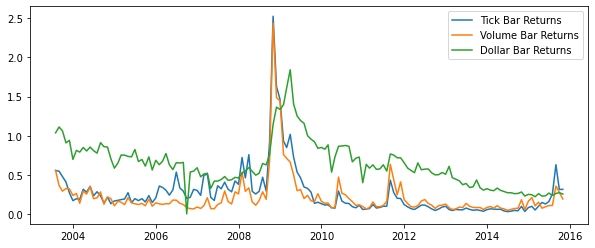

In [78]:
plt.figure(figsize=(10,4))
plt.plot(variances)
plt.legend(variances.columns)

In [79]:
variances.mean(axis=0)

Tick Bar Returns      0.262950
Volume Bar Returns    0.217157
Dollar Bar Returns    0.631709
dtype: float64

In [80]:
variances.var(axis=0)

Tick Bar Returns      0.096381
Volume Bar Returns    0.074700
Dollar Bar Returns    0.087394
dtype: float64

Unfortunately, Dollar bars do not have the lowest variance of variances. In this case, **volume bars** is the winner!

# Jarque-Bera Test

For the last section, we will apply the Jarque-Bera Normality test. This test is easily implemented using SciPy. 

In [81]:
from scipy import stats

stats.jarque_bera(tick_pxrets['Tick Bar Returns'])

Jarque_beraResult(statistic=60861.954426052274, pvalue=0.0)

In [82]:
stats.jarque_bera(volume_pxrets['Volume Bar Returns'])

Jarque_beraResult(statistic=45993.44612361124, pvalue=0.0)

In [83]:
stats.jarque_bera(dollar_pxrets['Dollar Bar Returns'])

Jarque_beraResult(statistic=658.726270586072, pvalue=0.0)

Since all of the p-values are $<0.05$, we can reject the null hypothesis that returns are **not** normally distributed. We can easily see that **dollar bars win with the lowest test statistic!** It is the lowest by orders of magnitude! Given these results, I think that Dollar Bars behave the most like an IID normal locally, and then when a crash occurs, it misbehaves!

Just because I'm curious:

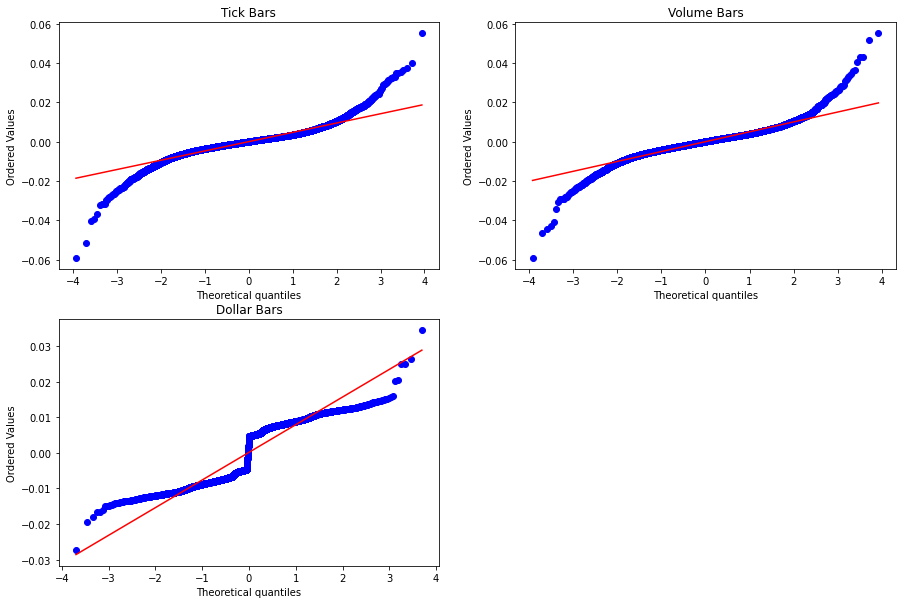

In [84]:
import pylab

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
stats.probplot(tick_pxrets['Tick Bar Returns'], dist="norm", plot=pylab)
plt.title('Tick Bars')
plt.subplot(2,2,2)
stats.probplot(volume_pxrets['Volume Bar Returns'], dist="norm", plot=pylab)
plt.title('Volume Bars')
plt.subplot(2,2,3)
stats.probplot(dollar_pxrets['Dollar Bar Returns'], dist="norm", plot=pylab)
plt.title('Dollar Bars')
pylab.show()

Errr..... This looks a little strange....